In [16]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Loading Price Data

In [17]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(project_root, '..', '..', 'data')

# Summer month
p_summer = pd.read_csv(os.path.join(data_dir, 'Spotmarket_August_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_summer['price_EUR_MWh'] = p_summer['price_EUR_MWh'] / 1000
p_summer.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

# Winter month
p_winter = pd.read_csv(os.path.join(data_dir, 'Spotmarket_December_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_winter['price_EUR_MWh'] = p_winter['price_EUR_MWh'] / 1000
p_winter.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12

### Loading Fixed Appliances Data

In [18]:
#TV consumption data for summer month
tv_summer = pd.read_csv(os.path.join(data_dir, 'tv_consumption_august_2024_detailed.csv'), sep=',')

#TV consumption data for winter month
tv_winter = pd.read_csv(os.path.join(data_dir, 'tv_consumption_december_2024_detailed.csv'), sep=',')

#Lighting consumption data for summer month
lighting_summer = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_august_2024.csv'), sep=',')

#Lighting consumption data for winter month
lighting_winter = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_december_2024.csv'), sep=',')

#Fridge consumption data for summer month
fridge_summer = pd.read_csv(os.path.join(data_dir, 'fridge_August_Final_Adjusted.csv'), sep=',')

#Fridge consumption data for winter month
fridge_winter = pd.read_csv(os.path.join(data_dir, 'fridge_December_Final_Adjusted.csv'), sep=',')

#Oven consumption data for summer month
oven_summer = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_August_Final.csv'),sep=',')

#Oven consumption data for winter month
oven_winter = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_December_Final.csv'),sep=',')

#Induction stove consumption data for summer month
induction_summer = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_August_Final.csv'),sep=',')

#Induction stove consumption data for winter month
induction_winter = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_December_Final.csv'),sep=',')

#adjust names of columns for summer
p_summer.columns = p_summer.columns.str.replace('price_EUR_MWh', 'Spotmarket_(EUR/kWh)')
tv_summer.columns = tv_summer.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_summer.columns = lighting_summer.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_summer.columns = fridge_summer.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_summer.columns = oven_summer.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_summer.columns = induction_summer.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')

#adjust names of columns for winter
p_winter.columns = p_winter.columns.str.replace('price_EUR_MWh', 'Spotmarket_(EUR/kWh)')
tv_winter.columns = tv_winter.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_winter.columns = lighting_winter.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_winter.columns = fridge_winter.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_winter.columns = oven_winter.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_winter.columns = induction_winter.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')


### Building Database

In [19]:
# Ensure all timestamp columns are of the same type for summer
p_summer['timestamp'] = pd.to_datetime(p_summer['timestamp'])
lighting_summer['timestamp'] = pd.to_datetime(lighting_summer['timestamp'])
fridge_summer['timestamp'] = pd.to_datetime(fridge_summer['timestamp'])
fridge_summer['timestamp'] = fridge_summer['timestamp'] - pd.Timedelta(hours=1)
oven_summer['timestamp'] = pd.to_datetime(oven_summer['timestamp'])
induction_summer['timestamp'] = pd.to_datetime(induction_summer['timestamp'])
tv_summer['timestamp'] = pd.to_datetime(tv_summer['timestamp'])

# Ensure all timestamp columns are of the same type for winter
p_winter['timestamp'] = pd.to_datetime(p_winter['timestamp'])
lighting_winter['timestamp'] = pd.to_datetime(lighting_winter['timestamp'])
fridge_winter['timestamp'] = pd.to_datetime(fridge_winter['timestamp'])
fridge_winter['timestamp'] = fridge_winter['timestamp'] - pd.Timedelta(hours=1)
oven_winter['timestamp'] = pd.to_datetime(oven_winter['timestamp'])
induction_winter['timestamp'] = pd.to_datetime(induction_winter['timestamp'])
induction_winter['timestamp'] = induction_winter['timestamp'].apply(lambda x: x.replace(year=2024))
tv_winter['timestamp'] = pd.to_datetime(tv_winter['timestamp'])

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for summer
lighting_summer = lighting_summer.iloc[:4 * 7 * 24]
fridge_summer = fridge_summer.iloc[:4 * 7 * 24]
oven_summer = oven_summer.iloc[:4 * 7 * 24]
induction_summer = induction_summer.iloc[:4 * 7 * 24]
tv_summer = tv_summer.iloc[:4 * 7 * 24]
p_summer = p_summer.iloc[:4 * 7 * 24]

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for winter
lighting_winter = lighting_winter.iloc[:4 * 7 * 24]
fridge_winter = fridge_winter.iloc[:4 * 7 * 24]
oven_winter = oven_winter.iloc[:4 * 7 * 24]
induction_winter = induction_winter.iloc[:4 * 7 * 24]
tv_winter = tv_winter.iloc[:4 * 7 * 24]
p_winter = p_winter.iloc[:4 * 7 * 24]

# Merge all datasets on the 'timestamp' column for summer
merged_data_summer = p_summer.merge(lighting_summer, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_summer, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_summer, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_summer, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_summer, left_on='timestamp', right_on='timestamp', how='inner') \

#Merge all datasets on the 'timestamp' column for winter
merged_data_winter = p_winter.merge(lighting_winter, left_on='timestamp', right_on='timestamp', how='inner') \
    .merge(oven_winter, left_on='timestamp', right_on='timestamp', how='inner') \
        .merge(tv_winter, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                    
#Add heat demand for winter
print(len(merged_data_winter['timestamp']))
heat_demand_winter = pd.read_csv(os.path.join(data_dir, 'heating_demand_december.csv'), sep=',')
merged_data_winter['Heating_Demand_(kWh)'] = heat_demand_winter['Hot water + Space Heating demand [kWh]']
# Display the merged dataset
#print(merged_data_summer)
#print(merged_data_winter)

672


### Optimization

In [20]:
# Load fixed appliences
price = merged_data_winter["Spotmarket_(EUR/kWh)"].values
fridge = merged_data_winter["Fridges_Consumption_(kWh)"].values
stove = merged_data_winter["Induction_Stove_Consumption_(kWh)"].values
oven = merged_data_winter["Oven_Consumption_(kWh)"].values
tv = merged_data_winter["TV_Consumption_(kWh)"].values
lighting = merged_data_winter["Lighting_Consumption_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Gurobi model
model = gp.Model("automated_demand_response")

Dishwasher

In [21]:
# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"max_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)- min_gap - duration):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + duration)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")

model.update()

Washing Machine

In [22]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if dishwasher is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the washing machine has to run twice per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks-1):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm) - min_gap_wm - duration_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + duration_wm)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_winter['Allowed_WM_winter'] = 0 # Initialize with 0

for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_winter.at[index, 'Allowed_WM_winter'] = 1
    else: 
        merged_data_winter.at[index, 'Allowed_WM_winter'] = 0
        
model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter")

model.update()

Heat Pump

In [23]:
# Heat pump and storage parameters
# https://www.ochsner.com/de-ch/ochsner-produkte/air-11-c11a/
COP = 4.2  # Coefficient of Performance
max_power_hp = 8  # kW, electrical power input
storage_capacity = 200  # kWh, thermal storage capacity
storage_loss_rate = 0.01  # 1% loss per hour

#binary_hp = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_hp")
power_hp = model.addVars(Time_interval, lb=0, ub=max_power_hp, vtype=GRB.CONTINUOUS, name="power_hp")
heat_output = model.addVars(Time_interval, lb=0, ub=COP*max_power_hp, vtype=GRB.CONTINUOUS, name="heat_output")
storage_level = model.addVars(Time_interval, lb=0.2*storage_capacity, ub=storage_capacity, vtype=GRB.CONTINUOUS, name="heat_storage")

# Heat output from heat pump
for t in range(Time_interval):
    model.addConstr(heat_output[t] == COP * power_hp[t], name=f"heat_output_{t}")

# Storage level dynamics
for t in range(Time_interval):
    if t == 0:
        model.addConstr(
            storage_level[t] == 0.5 * storage_capacity, name=f"storage_balance_{t}"
        )
    else:
        model.addConstr(
            storage_level[t] == storage_level[t - 1] * (1 - storage_loss_rate) + heat_output[t] - merged_data_winter['Heating_Demand_(kWh)'][t],
            name=f"storage_balance_{t}"
        )

model.update()

In [24]:
### Optimize

# Total power consumption including fixed and dishwasher
total_load = [fridge[t] + stove[t] + tv[t] + lighting[t] + power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] + power_hp[t] for t in range(672)]

# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * total_load[t] for t in range(672)), GRB.MINIMIZE)

# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8083 rows, 5373 columns and 30957 nonzeros
Model fingerprint: 0xc2c36d30
Variable types: 2016 continuous, 3357 integer (3357 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e-02, 9e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+02]
Presolve removed 6884 rows and 4076 columns
Presolve time: 0.31s
Presolved: 1199 rows, 1297 columns, 13451 nonzeros
Variable types: 0 continuous, 1297 integer (1297 binary)
Found heuristic solution: objective 131.8508100
Found heuristic solution: objective 128.3867250
Found heuristic solution: objective 127.7032950

Root relaxation: objective 1.260183e+02, 475 iterations, 0.03 seconds (0.00 work units)

    Nodes    |    Current Node  

In [25]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {p_winter['timestamp'][t]}")
            wm_starts_list.append(p_winter['timestamp'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 126.02
Washing machine starts at: 2024-12-01 08:00:00
Washing machine starts at: 2024-12-01 11:00:00
Washing machine starts at: 2024-12-01 14:00:00
Washing machine starts at: 2024-12-07 12:00:00
Washing machine starts at: 2024-12-08 08:00:00
Washing machine starts at: 2024-12-08 12:00:00
Washing machine starts at: 2024-12-14 10:00:00
Washing machine starts at: 2024-12-14 13:00:00
Washing machine starts at: 2024-12-15 08:00:00
Washing machine starts at: 2024-12-15 13:00:00
Washing machine starts at: 2024-12-15 18:00:00
Washing machine starts at: 2024-12-21 12:00:00
Washing machine schedule:
[Timestamp('2024-12-01 08:00:00'), Timestamp('2024-12-01 11:00:00'), Timestamp('2024-12-01 14:00:00'), Timestamp('2024-12-07 12:00:00'), Timestamp('2024-12-08 08:00:00'), Timestamp('2024-12-08 12:00:00'), Timestamp('2024-12-14 10:00:00'), Timestamp('2024-12-14 13:00:00'), Timestamp('2024-12-15 08:00:00'), Timestamp('2024-12-15 13:00:00'), Timestamp('2024-12-15 18:00:00'), Timestamp('2024-

In [26]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {p_winter['timestamp'][t]}")
        else:
            print(f"Washing Machine is OFF at: {p_winter['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2024-12-01 00:00:00
Washing Machine is OFF at: 2024-12-01 01:00:00
Washing Machine is OFF at: 2024-12-01 02:00:00
Washing Machine is OFF at: 2024-12-01 03:00:00
Washing Machine is OFF at: 2024-12-01 04:00:00
Washing Machine is OFF at: 2024-12-01 05:00:00
Washing Machine is OFF at: 2024-12-01 06:00:00
Washing Machine is OFF at: 2024-12-01 07:00:00
Washing Machine is ON at: 2024-12-01 08:00:00
Washing Machine is ON at: 2024-12-01 09:00:00
Washing Machine is OFF at: 2024-12-01 10:00:00
Washing Machine is ON at: 2024-12-01 11:00:00
Washing Machine is ON at: 2024-12-01 12:00:00
Washing Machine is OFF at: 2024-12-01 13:00:00
Washing Machine is ON at: 2024-12-01 14:00:00
Washing Machine is ON at: 2024-12-01 15:00:00
Washing Machine is OFF at: 2024-12-01 16:00:00
Washing Machine is OFF at: 2024-12-01 17:00:00
Washing Machine is OFF at: 2024-12-01 18:00:00
Washing Machine is OFF at: 2024-12-01 19:00:00
Washing Machine is OFF at: 2024-12-01 20:00:00
Washing Machine is 

In [27]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {p_winter['timestamp'][t]}")
            dishwasher_starts_list.append(p_winter['timestamp'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 126.02
Dishwasher starts at: 2024-12-01 04:00:00
Dishwasher starts at: 2024-12-02 02:00:00
Dishwasher starts at: 2024-12-03 02:00:00
Dishwasher starts at: 2024-12-04 02:00:00
Dishwasher starts at: 2024-12-05 02:00:00
Dishwasher starts at: 2024-12-06 02:00:00
Dishwasher starts at: 2024-12-07 03:00:00
Dishwasher starts at: 2024-12-08 02:00:00
Dishwasher starts at: 2024-12-09 02:00:00
Dishwasher starts at: 2024-12-10 01:00:00
Dishwasher starts at: 2024-12-11 02:00:00
Dishwasher starts at: 2024-12-12 01:00:00
Dishwasher starts at: 2024-12-13 02:00:00
Dishwasher starts at: 2024-12-14 02:00:00
Dishwasher starts at: 2024-12-15 06:00:00
Dishwasher starts at: 2024-12-16 02:00:00
Dishwasher starts at: 2024-12-17 00:00:00
Dishwasher starts at: 2024-12-18 02:00:00
Dishwasher starts at: 2024-12-19 02:00:00
Dishwasher starts at: 2024-12-20 02:00:00
Dishwasher starts at: 2024-12-21 02:00:00
Dishwasher starts at: 2024-12-22 03:00:00
Dishwasher starts at: 2024-12-23 02:00:00
Dishwasher star

In [28]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {p_winter['timestamp'][t]}")
        else:
            print(f"Dishwasher is OFF at: {p_winter['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is OFF at: 2024-12-01 00:00:00
Dishwasher is OFF at: 2024-12-01 01:00:00
Dishwasher is OFF at: 2024-12-01 02:00:00
Dishwasher is OFF at: 2024-12-01 03:00:00
Dishwasher is ON at: 2024-12-01 04:00:00
Dishwasher is ON at: 2024-12-01 05:00:00
Dishwasher is ON at: 2024-12-01 06:00:00
Dishwasher is OFF at: 2024-12-01 07:00:00
Dishwasher is OFF at: 2024-12-01 08:00:00
Dishwasher is OFF at: 2024-12-01 09:00:00
Dishwasher is OFF at: 2024-12-01 10:00:00
Dishwasher is OFF at: 2024-12-01 11:00:00
Dishwasher is OFF at: 2024-12-01 12:00:00
Dishwasher is OFF at: 2024-12-01 13:00:00
Dishwasher is OFF at: 2024-12-01 14:00:00
Dishwasher is OFF at: 2024-12-01 15:00:00
Dishwasher is OFF at: 2024-12-01 16:00:00
Dishwasher is OFF at: 2024-12-01 17:00:00
Dishwasher is OFF at: 2024-12-01 18:00:00
Dishwasher is OFF at: 2024-12-01 19:00:00
Dishwasher is OFF at: 2024-12-01 20:00:00
Dishwasher is OFF at: 2024-12-01 21:00:00
Dishwasher is OFF at: 2024-12-01 22:00:00
Dishwasher is OFF at: 2024-12-01 23:0

In [29]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {p_winter['timestamp'][t]}")

Dishwasher start time: 2024-12-01 04:00:00
Dishwasher start time: 2024-12-02 02:00:00
Dishwasher start time: 2024-12-03 02:00:00
Dishwasher start time: 2024-12-04 02:00:00
Dishwasher start time: 2024-12-05 02:00:00
Dishwasher start time: 2024-12-06 02:00:00
Dishwasher start time: 2024-12-07 03:00:00
Dishwasher start time: 2024-12-08 02:00:00
Dishwasher start time: 2024-12-09 02:00:00
Dishwasher start time: 2024-12-10 01:00:00
Dishwasher start time: 2024-12-11 02:00:00
Dishwasher start time: 2024-12-12 01:00:00
Dishwasher start time: 2024-12-13 02:00:00
Dishwasher start time: 2024-12-14 02:00:00
Dishwasher start time: 2024-12-15 06:00:00
Dishwasher start time: 2024-12-16 02:00:00
Dishwasher start time: 2024-12-17 00:00:00
Dishwasher start time: 2024-12-18 02:00:00
Dishwasher start time: 2024-12-19 02:00:00
Dishwasher start time: 2024-12-20 02:00:00
Dishwasher start time: 2024-12-21 02:00:00
Dishwasher start time: 2024-12-22 03:00:00
Dishwasher start time: 2024-12-23 02:00:00
Dishwasher 

In [30]:
#print dishwasher start times
for t in range(Time_interval-1):
    if power_hp[t].X > 0:
        print(f"Heatpump runtime: {p_winter['timestamp'][t]}")

Heatpump runtime: 2024-12-02 23:00:00
Heatpump runtime: 2024-12-04 01:00:00
Heatpump runtime: 2024-12-04 02:00:00
Heatpump runtime: 2024-12-04 03:00:00
Heatpump runtime: 2024-12-04 21:00:00
Heatpump runtime: 2024-12-04 22:00:00
Heatpump runtime: 2024-12-04 23:00:00
Heatpump runtime: 2024-12-05 00:00:00
Heatpump runtime: 2024-12-05 01:00:00
Heatpump runtime: 2024-12-05 02:00:00
Heatpump runtime: 2024-12-05 03:00:00
Heatpump runtime: 2024-12-05 04:00:00
Heatpump runtime: 2024-12-05 23:00:00
Heatpump runtime: 2024-12-06 00:00:00
Heatpump runtime: 2024-12-06 01:00:00
Heatpump runtime: 2024-12-06 02:00:00
Heatpump runtime: 2024-12-06 03:00:00
Heatpump runtime: 2024-12-06 04:00:00
Heatpump runtime: 2024-12-06 21:00:00
Heatpump runtime: 2024-12-06 23:00:00
Heatpump runtime: 2024-12-07 00:00:00
Heatpump runtime: 2024-12-07 01:00:00
Heatpump runtime: 2024-12-07 02:00:00
Heatpump runtime: 2024-12-07 03:00:00
Heatpump runtime: 2024-12-07 04:00:00
Heatpump runtime: 2024-12-07 05:00:00
Heatpump run

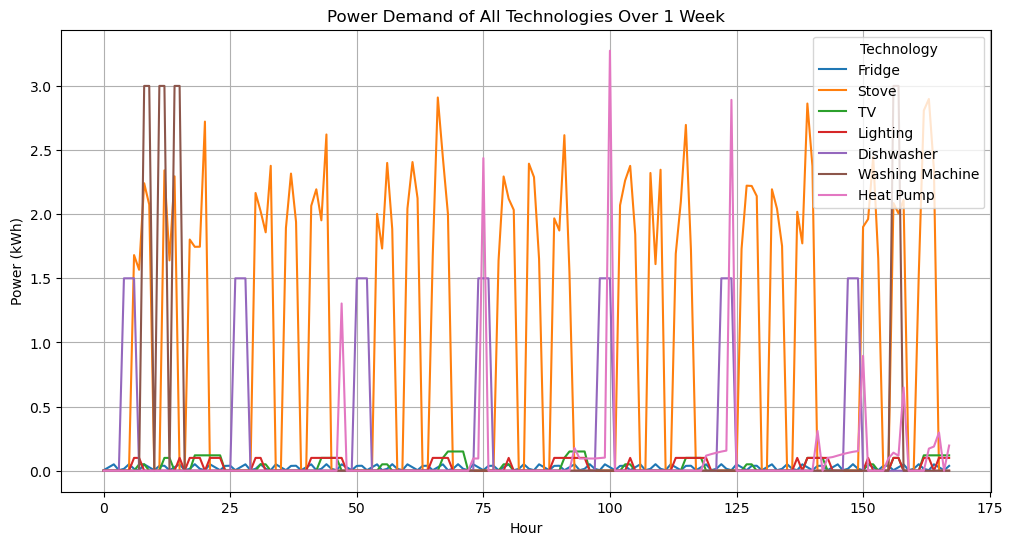

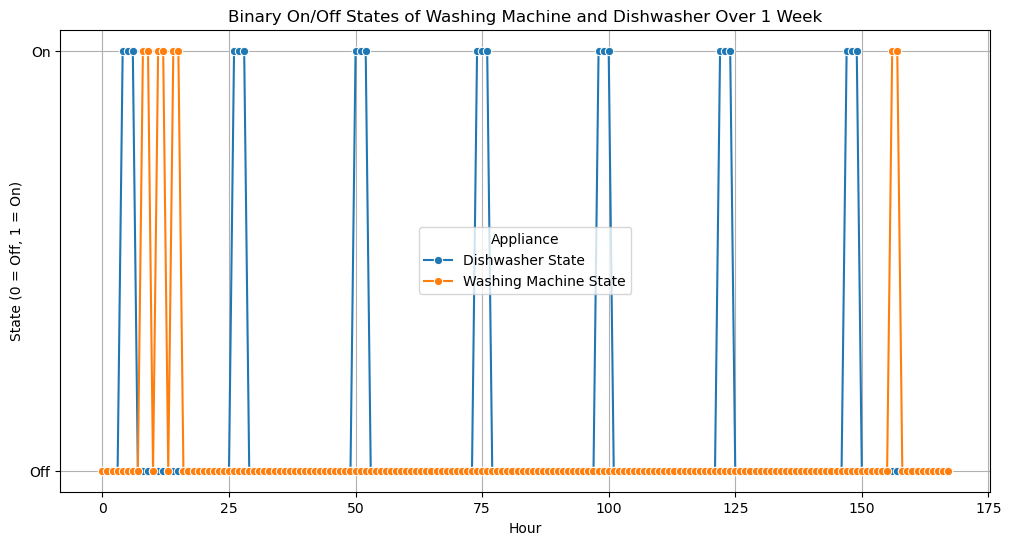

In [31]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Heat Pump': [power_hp[t].X for t in time_range],
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()
